<a href="https://colab.research.google.com/github/nourel25/Predict-Autism/blob/main/Autism%20%7C%20CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
!pip install fuzzywuzzy

In [121]:
!pip install catboost

In [122]:
!pip install optuna

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [124]:
df = pd.read_csv('/content/train.csv')

In [125]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [126]:
print('Data Shape:', df.shape)

Data Shape: (800, 22)




*   **Score Features:**
  *   A0 to A10
  *   result

*   **Demographic Features:**
  *   age
  *   gender
  *   ethnicity
  *   contry_of_res: Country of residence

*   **Medical Feature:**
  *   jaundice: Indicates if the person had jaundice at birth
  *   austim: Whether there is a family history of autism
  *   used_app_before

*    **Other Features:**
  *   age_desc: A description of the age group
  *   relation: The relationship of the person taking the test to the individual

*    **Targer Feature:**
  *   Class/ASD





In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [128]:
df.drop(['ID', 'Class/ASD'], axis=1).describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452118,8.537303
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,4.807676
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,-6.137748
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198153,5.306575
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848350,9.605299
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865429,12.514484
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461718,15.853126


In [129]:
for col in df.drop(['ID', 'age', 'result'], axis=1).columns:
  print(f"{col} Unique Values: {df[col].unique()} \n")
  print("="*15)

A1_Score Unique Values: [1 0] 

A2_Score Unique Values: [0 1] 

A3_Score Unique Values: [1 0] 

A4_Score Unique Values: [0 1] 

A5_Score Unique Values: [1 0] 

A6_Score Unique Values: [0 1] 

A7_Score Unique Values: [1 0] 

A8_Score Unique Values: [0 1] 

A9_Score Unique Values: [1 0] 

A10_Score Unique Values: [1 0] 

gender Unique Values: ['f' 'm'] 

ethnicity Unique Values: ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others'] 

jaundice Unique Values: ['no' 'yes'] 

austim Unique Values: ['no' 'yes'] 

contry_of_res Unique Values: ['Austria' 'India' 'United States' 'South Africa' 'Jordan'
 'United Kingdom' 'Brazil' 'New Zealand' 'Canada' 'Kazakhstan'
 'United Arab Emirates' 'Australia' 'Ukraine' 'Iraq' 'France' 'Malaysia'
 'Viet Nam' 'Egypt' 'Netherlands' 'Afghanistan' 'Oman' 'Italy'
 'AmericanSamoa' 'Bahamas' 'Saudi Arabia' 'Ireland' 'Aruba' 'Sri Lanka'
 'Russia' 'Bolivia' 'Azerbaijan' 'Armenia' 'Serbia' 

In [130]:
unique_countries = df['contry_of_res'].unique()

for country in unique_countries:
  matches = process.extract(country, unique_countries, limit=5,
                            scorer=fuzz.ratio)

  similar = [m for m in matches if m[1] >= 80 and m[0] != country]
  if similar:
      print(f"Potential duplicates for '{country}': {similar}")

Potential duplicates for 'Austria': [('Australia', 88)]
Potential duplicates for 'Australia': [('Austria', 88)]
Potential duplicates for 'Ireland': [('Iceland', 86)]
Potential duplicates for 'Iceland': [('Ireland', 86)]


In [131]:
df[['age', 'age_desc']]

,age,age_desc
0,38.172746,18 and more
1,47.750517,18 and more
2,7.380373,18 and more
3,23.561927,18 and more
4,43.205790,18 and more
...,...,...
795,16.597187,18 and more
796,20.703001,18 and more
797,5.711481,18 and more
798,16.414305,18 and more


In [132]:
df = df.drop(columns=['ID', 'age_desc'])

In [133]:
df['contry_of_res'] = df['contry_of_res'].replace({
    'Viet Nam': 'Vietnam',
    'AmericanSamoa': 'United States',
})

In [134]:
df = df.rename(columns = {'austim': 'autism',
                         'contry_of_res':'country_of_res'},
                          errors="raise")

In [135]:
sns.set_theme(style="darkgrid")

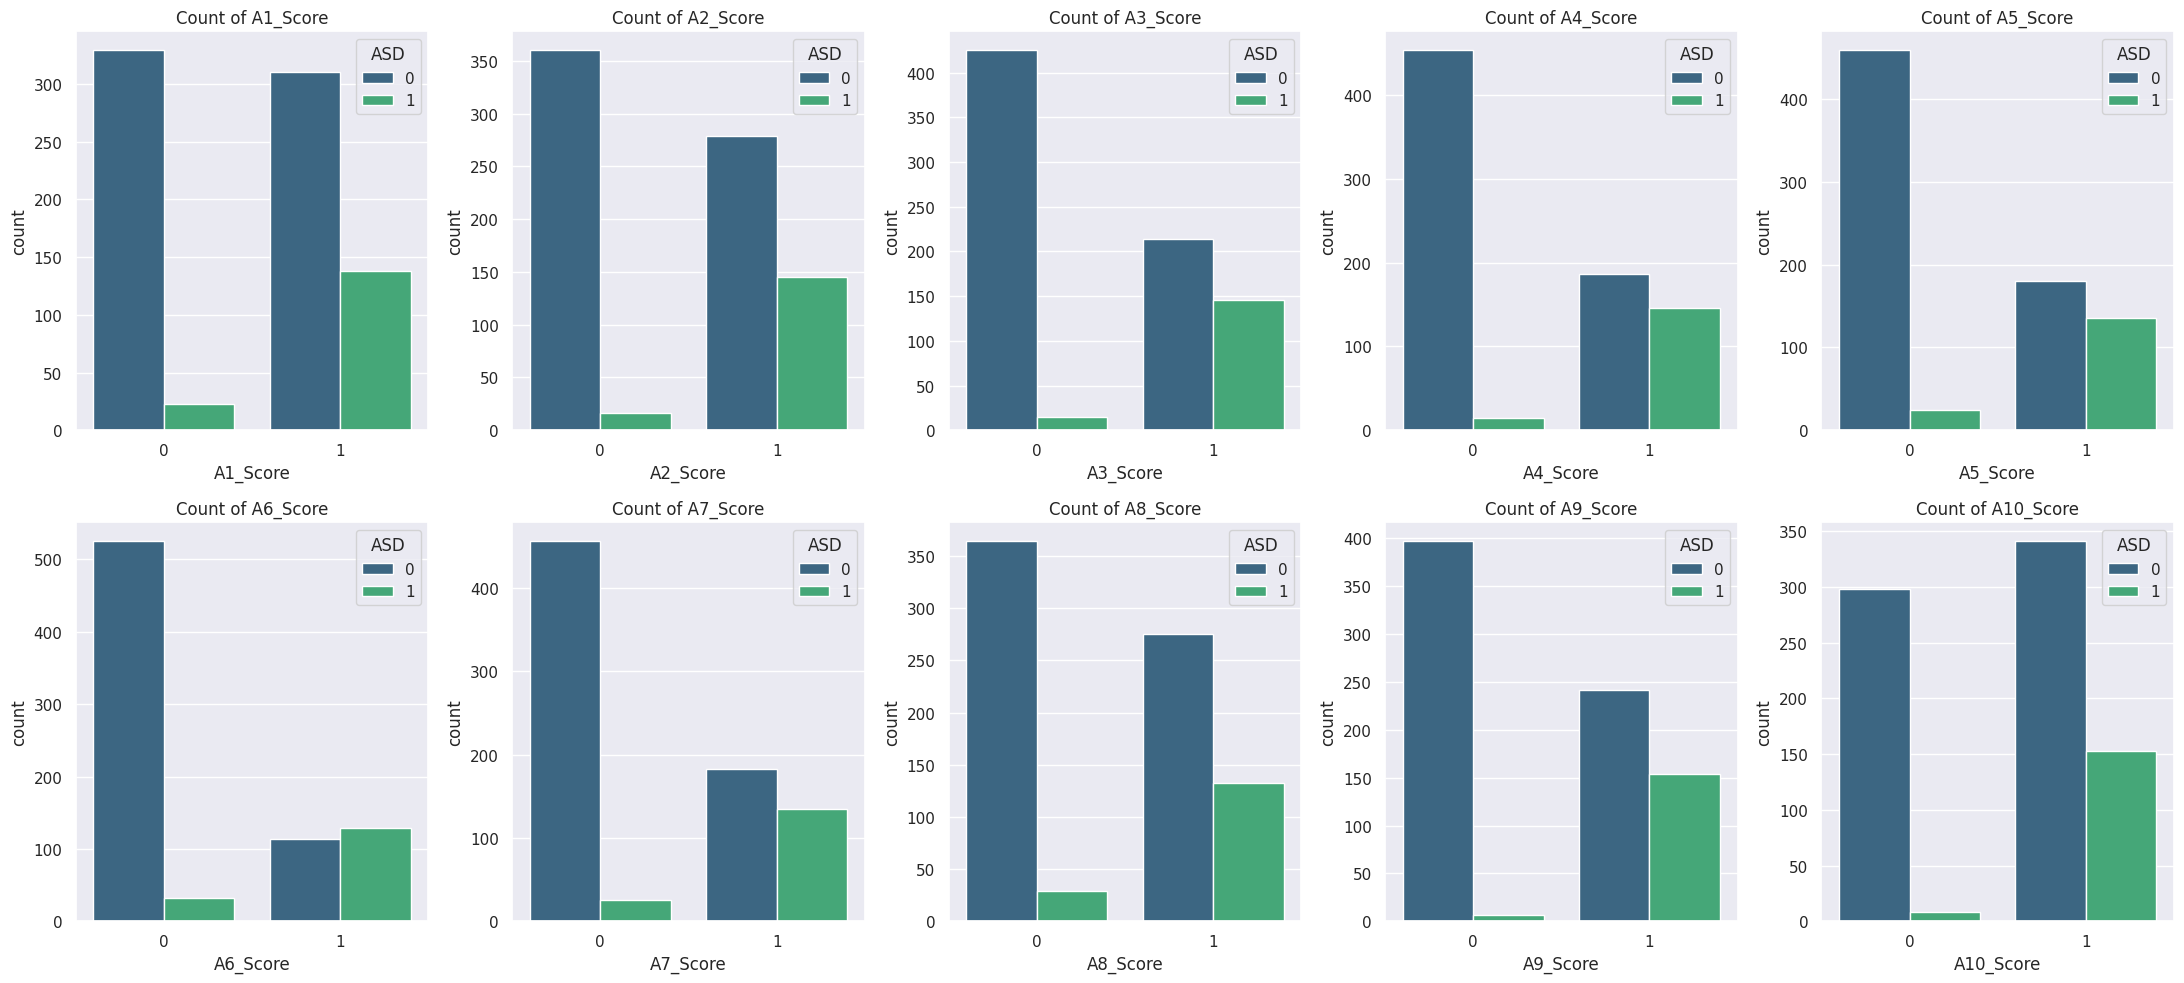

In [136]:
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(df.loc[:, 'A1_Score': 'A10_Score']):
  sns.countplot(x=col, data=df, hue='Class/ASD', palette='viridis', ax=axes[i])
  axes[i].set_title(f'Count of {col}')
  axes[i].legend(title='ASD')

plt.tight_layout()
plt.show()

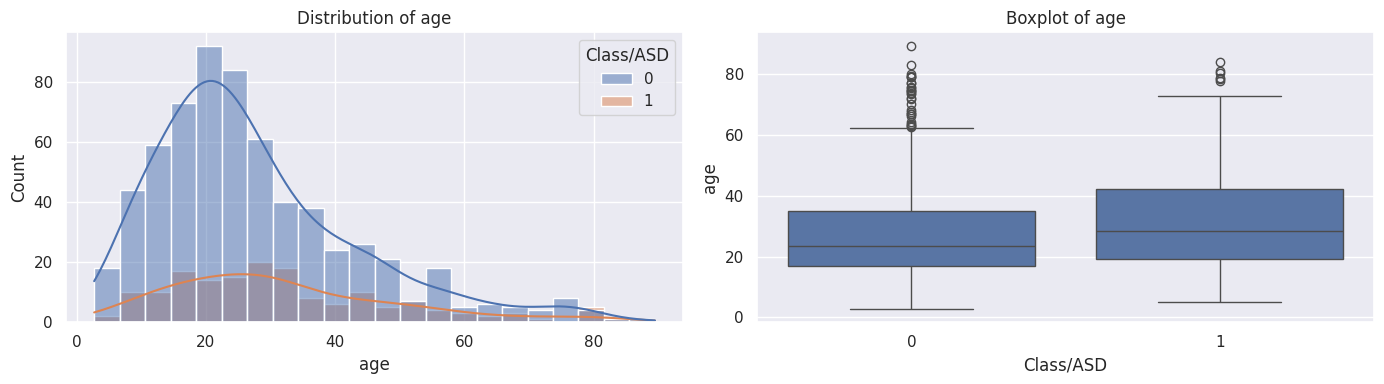

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(x='age', data=df, hue='Class/ASD', kde=True, ax=axes[0])
axes[0].set_title("Distribution of age")

sns.boxplot(y='age', x='Class/ASD', data=df, ax=axes[1])
axes[1].set_title("Boxplot of age")

plt.tight_layout()
plt.show()

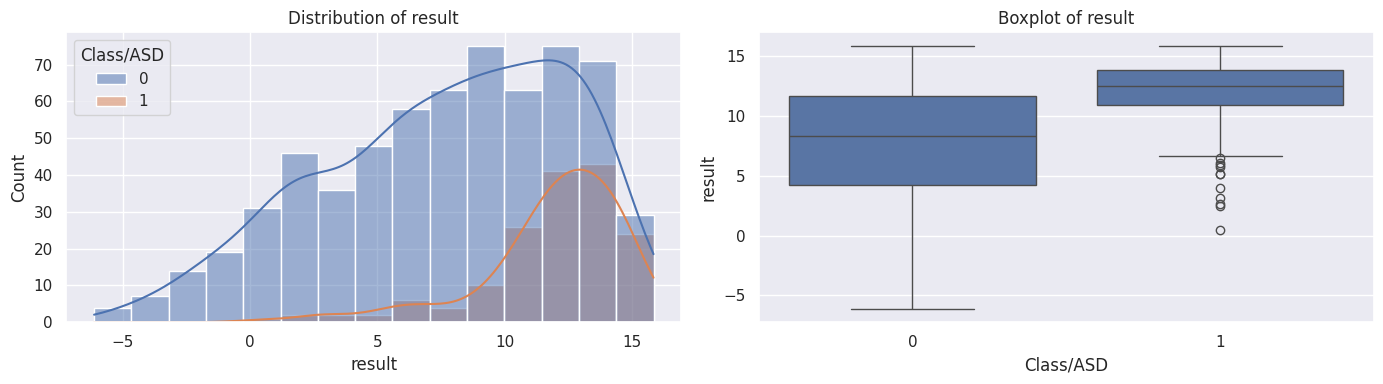

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(x='result', data=df, hue='Class/ASD', kde=True, ax=axes[0])
axes[0].set_title("Distribution of result")

sns.boxplot(y='result', x='Class/ASD', data=df, ax=axes[1])
axes[1].set_title("Boxplot of result")

plt.tight_layout()
plt.show()

In [139]:
gender_counts = df['gender'].value_counts()
jaundice_counts = df['jaundice'].value_counts()
autism_counts = df['autism'].value_counts()
used_app_counts = df['used_app_before'].value_counts()

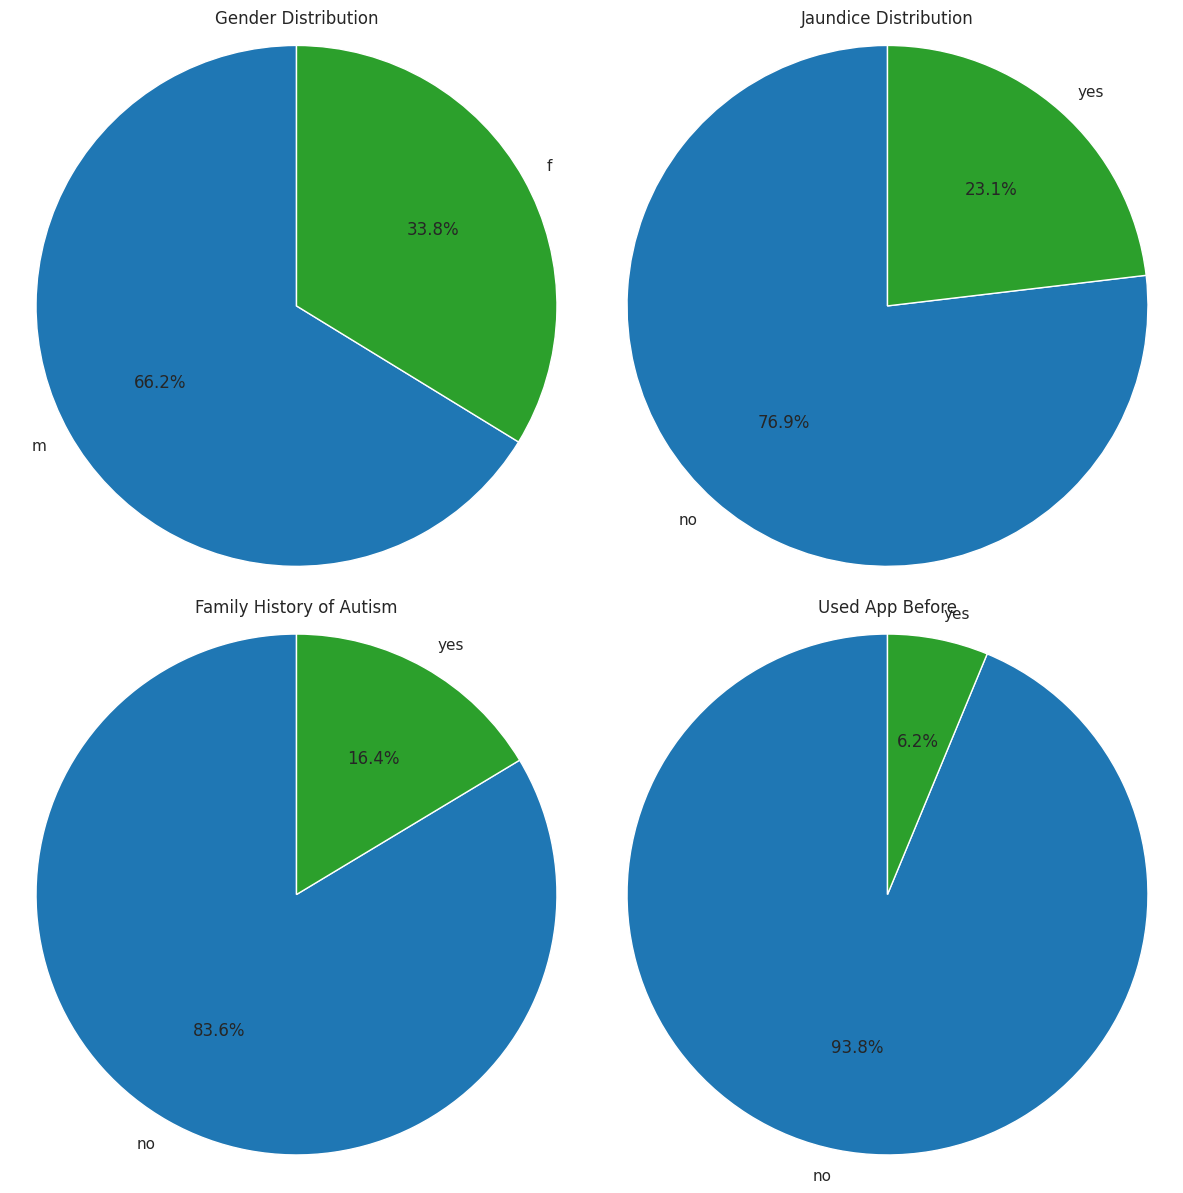

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Gender Pie Chart
axes[0, 0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#2ca02c'])
axes[0, 0].set_title('Gender Distribution')
axes[0, 0].axis('equal')

# Jaundice Pie Chart
axes[0, 1].pie(jaundice_counts, labels=jaundice_counts.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#2ca02c'])
axes[0, 1].set_title('Jaundice Distribution')
axes[0, 1].axis('equal')

# Autism (austim) Pie Chart
axes[1, 0].pie(autism_counts, labels=autism_counts.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#2ca02c'])
axes[1, 0].set_title('Family History of Autism')
axes[1, 0].axis('equal')

# Used App Before Pie Chart
axes[1, 1].pie(used_app_counts, labels=used_app_counts.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#2ca02c'])
axes[1, 1].set_title('Used App Before')
axes[1, 1].axis('equal')

plt.tight_layout()
plt.show()

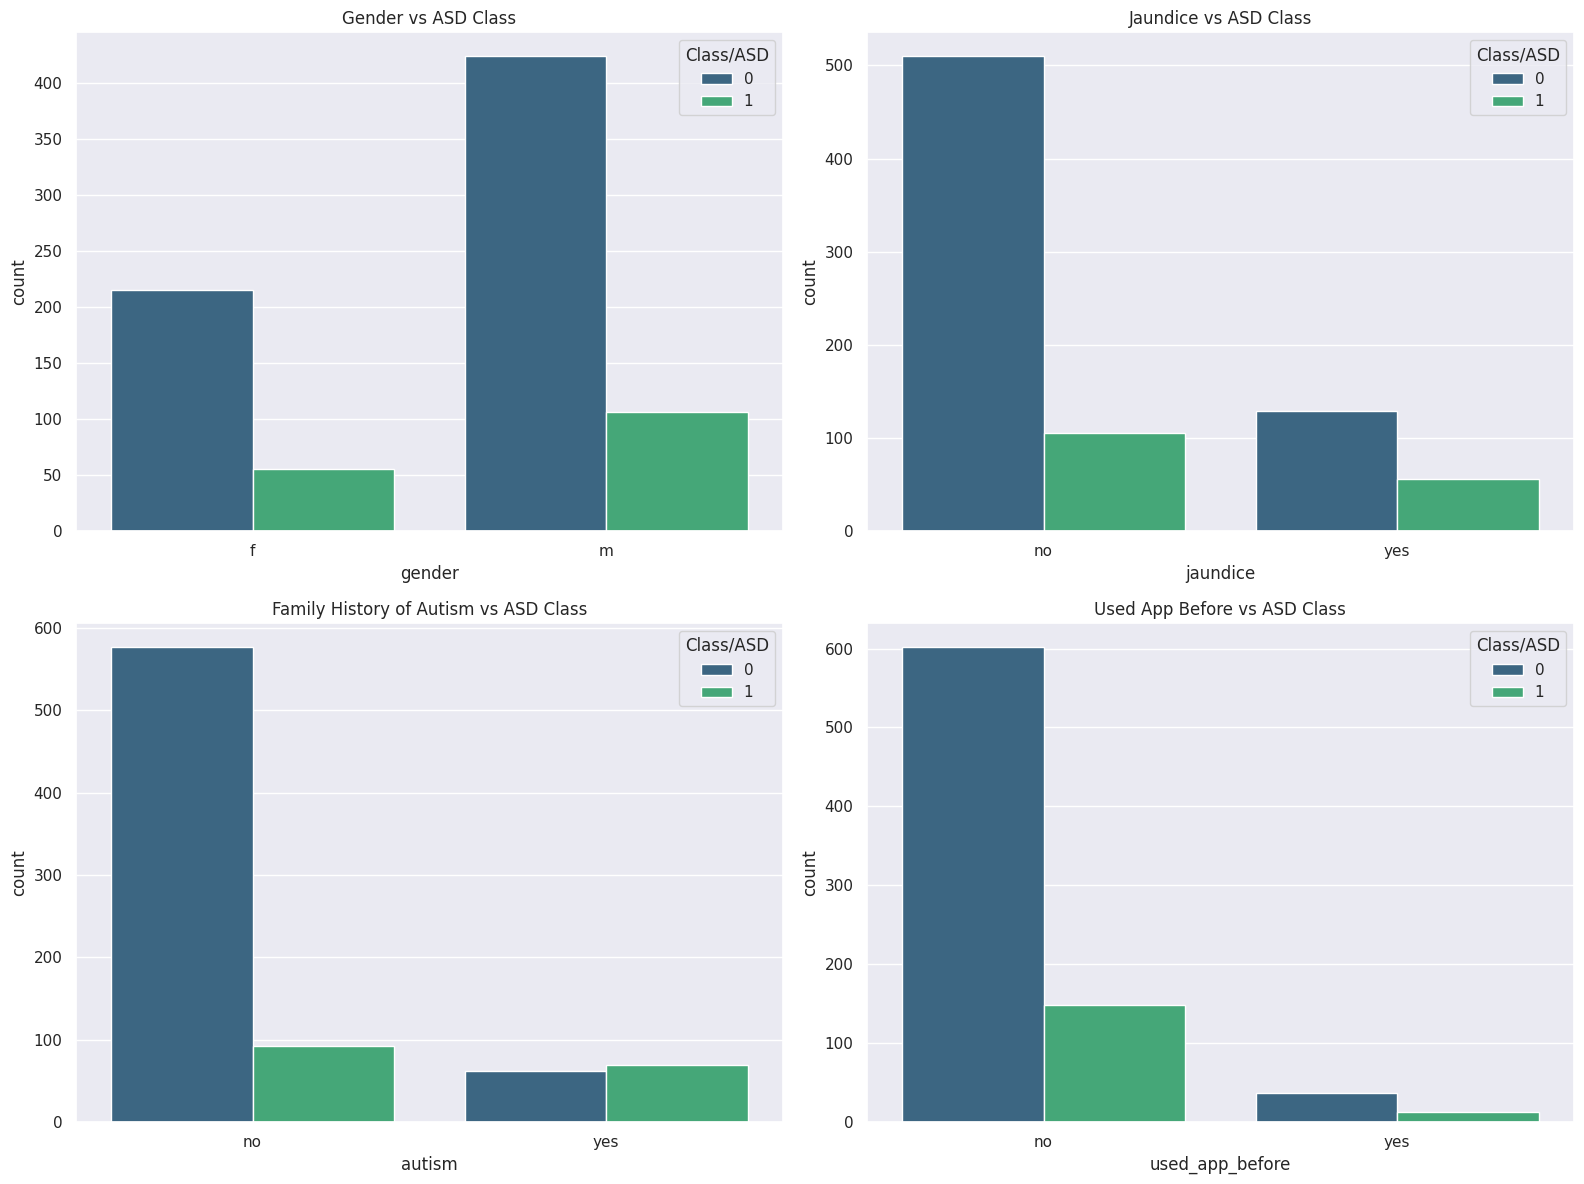

In [141]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gender vs ASD Class
sns.countplot(x='gender', hue='Class/ASD', data=df, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Gender vs ASD Class')

# Jaundice vs ASD Class
sns.countplot(x='jaundice', hue='Class/ASD', data=df, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Jaundice vs ASD Class')

# Family History of Autism vs ASD Class
sns.countplot(x='autism', hue='Class/ASD', data=df, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Family History of Autism vs ASD Class')

# Used App Before vs ASD Class
sns.countplot(x='used_app_before', hue='Class/ASD', data=df, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Used App Before vs ASD Class')

plt.tight_layout()
plt.show()

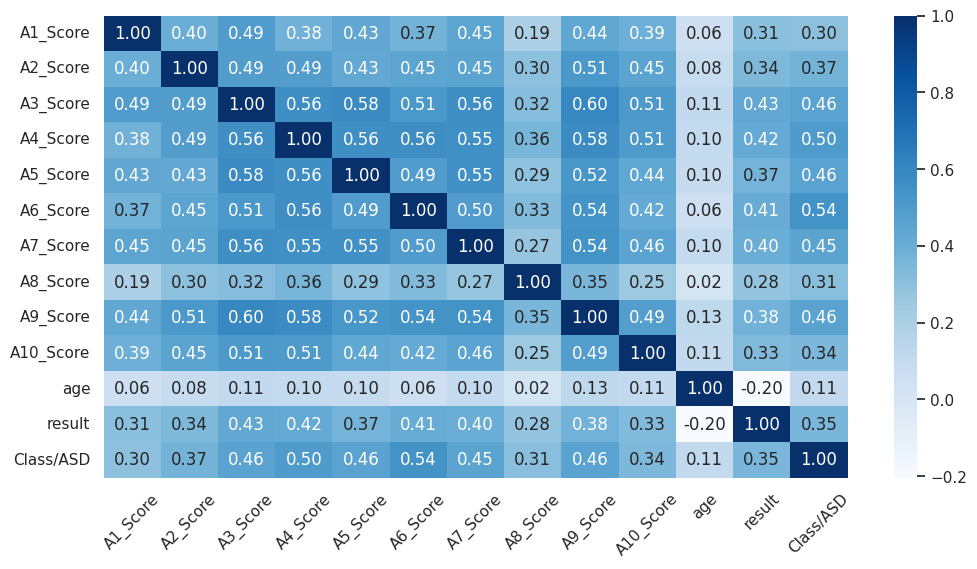

In [142]:
plt.figure(figsize=(10, 10))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.tick_params('x', rotation=45)
plt.show()

In [143]:
df["ethnicity"].unique()

array(['?', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino',
       'others'], dtype=object)

In [144]:
df['ethnicity'] = df['ethnicity'].replace({
    '?': 'Others',
    'others': 'Others'
})

In [145]:
df["relation"].unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)

In [146]:
df['relation'] = df['relation'].replace({
    '?': 'Others'
})

In [147]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   A1_Score         800 non-null    int64   
 1   A2_Score         800 non-null    int64   
 2   A3_Score         800 non-null    int64   
 3   A4_Score         800 non-null    int64   
 4   A5_Score         800 non-null    int64   
 5   A6_Score         800 non-null    int64   
 6   A7_Score         800 non-null    int64   
 7   A8_Score         800 non-null    int64   
 8   A9_Score         800 non-null    int64   
 9   A10_Score        800 non-null    int64   
 10  age              800 non-null    float64 
 11  gender           800 non-null    category
 12  ethnicity        800 non-null    category
 13  jaundice         800 non-null    category
 14  autism           800 non-null    category
 15  country_of_res   800 non-null    category
 16  used_app_before  800 non-null    category
 1

In [149]:
X = df.drop('Class/ASD', axis=1)
y = df['Class/ASD']

In [150]:
cat_cols = X.select_dtypes(include='category').columns
cat_cols

Index(['gender', 'ethnicity', 'jaundice', 'autism', 'country_of_res',
       'used_app_before', 'relation'],
      dtype='object')

In [151]:
num_cols = X.select_dtypes(include='number').columns
num_cols

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result'],
      dtype='object')

In [152]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [153]:
def objective_cat(trial):
    params = {
        "depth": trial.suggest_int("depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 150, 800),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": 0,
        "random_state": 42,
        "cat_features": list(cat_cols)
    }

    thr = trial.suggest_float("threshold", 0.05, 0.95)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    acc_scores = []

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
      X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]

      model = CatBoostClassifier(**params)

      model.fit(
          X_train, y_train,
          eval_set=[(X_val, y_val)])

      proba = model.predict_proba(X_val)[:, 1]
      preds = (proba >= thr).astype(int)
      f1_scores.append(f1_score(y_val, preds))
      acc_scores.append(accuracy_score(y_val, preds))

    print(np.mean(acc_scores))
    return np.mean(f1_scores)

In [154]:
cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(objective_cat, n_trials=125)

print('Best Score:', cat_study.best_value)
print('Best params:', cat_study.best_params)

[I 2025-07-13 15:59:11,003] A new study created in memory with name: no-name-7e6b756e-6dfb-4aba-a15a-f0b7a1bbb470
[I 2025-07-13 15:59:59,935] Trial 0 finished with value: 0.6495471091260565 and parameters: {'depth': 7, 'learning_rate': 0.01309040016839164, 'iterations': 606, 'l2_leaf_reg': 32.23174892760308, 'bagging_temperature': 0.8487136285253435, 'random_strength': 0.4598431549164004, 'border_count': 200, 'threshold': 0.21960999921335078}. Best is trial 0 with value: 0.6495471091260565.


0.8208333333333334


[I 2025-07-13 16:00:13,093] Trial 1 finished with value: 0.5176590214306304 and parameters: {'depth': 6, 'learning_rate': 0.002165555116988799, 'iterations': 352, 'l2_leaf_reg': 1.1982738893450147, 'bagging_temperature': 0.4235597861554231, 'random_strength': 1.6672018996463276, 'border_count': 82, 'threshold': 0.17284594794055708}. Best is trial 0 with value: 0.6495471091260565.


0.6541666666666667


[I 2025-07-13 16:01:24,402] Trial 2 finished with value: 0.6332605971450365 and parameters: {'depth': 8, 'learning_rate': 0.19366367942145352, 'iterations': 735, 'l2_leaf_reg': 1.6354374861358867, 'bagging_temperature': 0.9448029345813566, 'random_strength': 1.5582349531369817, 'border_count': 213, 'threshold': 0.2910465851125937}. Best is trial 0 with value: 0.6495471091260565.


0.8375


[I 2025-07-13 16:01:41,277] Trial 3 finished with value: 0.6647773120664164 and parameters: {'depth': 3, 'learning_rate': 0.012117523652164536, 'iterations': 760, 'l2_leaf_reg': 18.00994084767158, 'bagging_temperature': 0.8268088150023486, 'random_strength': 0.6284150199250687, 'border_count': 160, 'threshold': 0.25677829512331557}. Best is trial 3 with value: 0.6647773120664164.


0.8388888888888888


[I 2025-07-13 16:02:07,027] Trial 4 finished with value: 0.0 and parameters: {'depth': 7, 'learning_rate': 0.007199121650649424, 'iterations': 514, 'l2_leaf_reg': 1.0582074093985843, 'bagging_temperature': 0.6980005322462604, 'random_strength': 1.5452588029352696, 'border_count': 85, 'threshold': 0.8663069011746355}. Best is trial 3 with value: 0.6647773120664164.


0.8041666666666668


[I 2025-07-13 16:02:29,322] Trial 5 finished with value: 0.6558856958075585 and parameters: {'depth': 5, 'learning_rate': 0.02435391085841168, 'iterations': 634, 'l2_leaf_reg': 3.901549270974286, 'bagging_temperature': 0.8106617143399459, 'random_strength': 0.6551953318193853, 'border_count': 229, 'threshold': 0.4594178210383208}. Best is trial 3 with value: 0.6647773120664164.


0.8694444444444445


[I 2025-07-13 16:03:08,423] Trial 6 finished with value: 0.608793242714406 and parameters: {'depth': 7, 'learning_rate': 0.03340781555041586, 'iterations': 644, 'l2_leaf_reg': 19.94149859228743, 'bagging_temperature': 0.37042855222183135, 'random_strength': 1.196156573957369, 'border_count': 217, 'threshold': 0.5582417288236297}. Best is trial 3 with value: 0.6647773120664164.


0.8680555555555556


[I 2025-07-13 16:03:36,209] Trial 7 finished with value: 0.6373740598472055 and parameters: {'depth': 7, 'learning_rate': 0.045703573041047774, 'iterations': 484, 'l2_leaf_reg': 34.05289413358732, 'bagging_temperature': 0.2572233786552528, 'random_strength': 1.138261807027623, 'border_count': 151, 'threshold': 0.5156713261113517}. Best is trial 3 with value: 0.6647773120664164.


0.8708333333333333


[I 2025-07-13 16:03:58,548] Trial 8 finished with value: 0.5811845636625467 and parameters: {'depth': 6, 'learning_rate': 0.02069745357387913, 'iterations': 517, 'l2_leaf_reg': 1.9876120565658872, 'bagging_temperature': 0.13424542125171213, 'random_strength': 0.38238583478808397, 'border_count': 59, 'threshold': 0.0778160367700194}. Best is trial 3 with value: 0.6647773120664164.


0.7347222222222222


[I 2025-07-13 16:04:47,318] Trial 9 finished with value: 0.6249702263115042 and parameters: {'depth': 8, 'learning_rate': 0.011936235692477688, 'iterations': 519, 'l2_leaf_reg': 1.4984219171993942, 'bagging_temperature': 0.30758708223744724, 'random_strength': 0.24482233126417063, 'border_count': 159, 'threshold': 0.42420237121900684}. Best is trial 3 with value: 0.6647773120664164.


0.8527777777777776


[I 2025-07-13 16:05:04,946] Trial 10 finished with value: 0.0 and parameters: {'depth': 3, 'learning_rate': 0.0010162039482338047, 'iterations': 798, 'l2_leaf_reg': 11.329341900863781, 'bagging_temperature': 0.6089652944662611, 'random_strength': 0.7317996709338084, 'border_count': 120, 'threshold': 0.7156478111326897}. Best is trial 3 with value: 0.6647773120664164.


0.8041666666666668


[I 2025-07-13 16:05:20,886] Trial 11 finished with value: 0.6736568989709907 and parameters: {'depth': 3, 'learning_rate': 0.07932586004548, 'iterations': 680, 'l2_leaf_reg': 4.767964906084921, 'bagging_temperature': 0.7687936911476805, 'random_strength': 0.7515889527237886, 'border_count': 245, 'threshold': 0.37137520911841004}. Best is trial 11 with value: 0.6736568989709907.


0.8652777777777778


[I 2025-07-13 16:05:27,093] Trial 12 finished with value: 0.6716380829657175 and parameters: {'depth': 3, 'learning_rate': 0.10913515299325352, 'iterations': 212, 'l2_leaf_reg': 6.225783807918792, 'bagging_temperature': 0.9995543005690493, 'random_strength': 0.8646478951504935, 'border_count': 250, 'threshold': 0.3227814143563629}. Best is trial 11 with value: 0.6736568989709907.


0.8555555555555557


[I 2025-07-13 16:05:29,039] Trial 13 finished with value: 0.6833376386823676 and parameters: {'depth': 4, 'learning_rate': 0.12784661201399908, 'iterations': 163, 'l2_leaf_reg': 5.072020750393805, 'bagging_temperature': 0.9698282416673396, 'random_strength': 0.9709593892223896, 'border_count': 242, 'threshold': 0.3120018268368357}. Best is trial 13 with value: 0.6833376386823676.


0.8597222222222223


[I 2025-07-13 16:05:31,127] Trial 14 finished with value: 0.5159542679151109 and parameters: {'depth': 4, 'learning_rate': 0.0703808961162597, 'iterations': 174, 'l2_leaf_reg': 3.3457523566652094, 'bagging_temperature': 0.6113829356953616, 'random_strength': 0.04604148734560365, 'border_count': 254, 'threshold': 0.6401128010974516}. Best is trial 13 with value: 0.6833376386823676.


0.8541666666666667


[I 2025-07-13 16:05:41,723] Trial 15 finished with value: 0.6927064147319402 and parameters: {'depth': 4, 'learning_rate': 0.17656215205314255, 'iterations': 360, 'l2_leaf_reg': 6.925317423567388, 'bagging_temperature': 0.7061634418847562, 'random_strength': 1.9626881950765203, 'border_count': 186, 'threshold': 0.36351856344699807}. Best is trial 15 with value: 0.6927064147319402.


0.8736111111111112


[I 2025-07-13 16:05:51,109] Trial 16 finished with value: 0.5609653606009697 and parameters: {'depth': 4, 'learning_rate': 0.19849995047573082, 'iterations': 301, 'l2_leaf_reg': 10.153574080116893, 'bagging_temperature': 0.5871659792015351, 'random_strength': 1.8772914798387121, 'border_count': 178, 'threshold': 0.054159357523677176}. Best is trial 15 with value: 0.6927064147319402.


0.711111111111111


[I 2025-07-13 16:06:01,867] Trial 17 finished with value: 0.6660487878105312 and parameters: {'depth': 4, 'learning_rate': 0.1171957517220603, 'iterations': 370, 'l2_leaf_reg': 7.502888749298277, 'bagging_temperature': 0.9229765301103557, 'random_strength': 1.2970471659181042, 'border_count': 123, 'threshold': 0.15952508101255208}. Best is trial 15 with value: 0.6927064147319402.


0.825


[I 2025-07-13 16:06:09,074] Trial 18 finished with value: 0.6664837939293473 and parameters: {'depth': 5, 'learning_rate': 0.005234582811276757, 'iterations': 249, 'l2_leaf_reg': 2.6118925536920794, 'bagging_temperature': 0.5306794372033649, 'random_strength': 1.9931774058537934, 'border_count': 186, 'threshold': 0.387829431394622}. Best is trial 15 with value: 0.6927064147319402.


0.8666666666666668


[I 2025-07-13 16:06:22,902] Trial 19 finished with value: 0.5428846564749201 and parameters: {'depth': 5, 'learning_rate': 0.055665631406204785, 'iterations': 408, 'l2_leaf_reg': 14.17336687112267, 'bagging_temperature': 0.718150822578473, 'random_strength': 1.0029203028763116, 'border_count': 187, 'threshold': 0.6289066625461697}. Best is trial 15 with value: 0.6927064147319402.


0.8597222222222222


[I 2025-07-13 16:06:31,546] Trial 20 finished with value: 0.6704999735412727 and parameters: {'depth': 4, 'learning_rate': 0.14311154875704965, 'iterations': 269, 'l2_leaf_reg': 6.510467239317537, 'bagging_temperature': 0.8788544410291218, 'random_strength': 1.3973625705635357, 'border_count': 227, 'threshold': 0.3280441562821783}. Best is trial 15 with value: 0.6927064147319402.


0.8541666666666666


[I 2025-07-13 16:06:33,058] Trial 21 finished with value: 0.6887499835886933 and parameters: {'depth': 3, 'learning_rate': 0.0816201486219336, 'iterations': 160, 'l2_leaf_reg': 4.548894350472586, 'bagging_temperature': 0.7265664451752887, 'random_strength': 0.9527899421497676, 'border_count': 239, 'threshold': 0.3728700943047277}. Best is trial 15 with value: 0.6927064147319402.


0.8708333333333333


[I 2025-07-13 16:06:35,234] Trial 22 finished with value: 0.6596101641056225 and parameters: {'depth': 4, 'learning_rate': 0.0899977849771475, 'iterations': 188, 'l2_leaf_reg': 2.756644743467084, 'bagging_temperature': 0.6977094484762248, 'random_strength': 0.9563446902784836, 'border_count': 232, 'threshold': 0.4776461043266744}. Best is trial 15 with value: 0.6927064147319402.


0.8722222222222223


[I 2025-07-13 16:06:36,682] Trial 23 finished with value: 0.6965728999089063 and parameters: {'depth': 3, 'learning_rate': 0.04223955775793135, 'iterations': 151, 'l2_leaf_reg': 5.479399926607821, 'bagging_temperature': 0.5153845988875603, 'random_strength': 1.1121853523448246, 'border_count': 206, 'threshold': 0.3914913079525322}. Best is trial 23 with value: 0.6965728999089063.


0.875


[I 2025-07-13 16:06:44,903] Trial 24 finished with value: 0.6155227673721132 and parameters: {'depth': 3, 'learning_rate': 0.039940421729858885, 'iterations': 309, 'l2_leaf_reg': 8.918701797651607, 'bagging_temperature': 0.47289531109587846, 'random_strength': 1.8222104294270118, 'border_count': 200, 'threshold': 0.5751992738255058}. Best is trial 23 with value: 0.6965728999089063.


0.8708333333333332


[I 2025-07-13 16:06:55,638] Trial 25 finished with value: 0.690764710183948 and parameters: {'depth': 3, 'learning_rate': 0.02739557132956203, 'iterations': 432, 'l2_leaf_reg': 4.251254170157263, 'bagging_temperature': 0.5412945724007603, 'random_strength': 1.393955648247881, 'border_count': 173, 'threshold': 0.4050667559237492}. Best is trial 23 with value: 0.6965728999089063.


0.8736111111111111


[I 2025-07-13 16:07:06,116] Trial 26 finished with value: 0.02 and parameters: {'depth': 3, 'learning_rate': 0.022112803838939585, 'iterations': 426, 'l2_leaf_reg': 2.9175297871769743, 'bagging_temperature': 0.513824895254578, 'random_strength': 1.4791011747304879, 'border_count': 132, 'threshold': 0.8111958029387197}. Best is trial 23 with value: 0.6965728999089063.


0.8041666666666668


[I 2025-07-13 16:07:21,402] Trial 27 finished with value: 0.6722682462905587 and parameters: {'depth': 4, 'learning_rate': 0.029542727162127653, 'iterations': 565, 'l2_leaf_reg': 5.9460556810739815, 'bagging_temperature': 0.4109054546962202, 'random_strength': 1.653856008865835, 'border_count': 171, 'threshold': 0.43960897617365857}. Best is trial 23 with value: 0.6965728999089063.


0.8736111111111112


[I 2025-07-13 16:07:35,764] Trial 28 finished with value: 0.6413196837198072 and parameters: {'depth': 5, 'learning_rate': 0.055695890406079585, 'iterations': 434, 'l2_leaf_reg': 13.854836759422465, 'bagging_temperature': 0.2204079313248556, 'random_strength': 1.3301267919225837, 'border_count': 140, 'threshold': 0.5190523280869433}. Best is trial 23 with value: 0.6965728999089063.


0.8708333333333333


[I 2025-07-13 16:07:51,822] Trial 29 finished with value: 0.6525765792293308 and parameters: {'depth': 3, 'learning_rate': 0.008058858463873844, 'iterations': 574, 'l2_leaf_reg': 22.263362111831533, 'bagging_temperature': 0.6271316045214319, 'random_strength': 1.7132400654614437, 'border_count': 209, 'threshold': 0.23798535314740454}. Best is trial 23 with value: 0.6965728999089063.


0.8291666666666666


[I 2025-07-13 16:08:03,912] Trial 30 finished with value: 0.6507797420069458 and parameters: {'depth': 4, 'learning_rate': 0.01692115394662097, 'iterations': 361, 'l2_leaf_reg': 7.8123737452740585, 'bagging_temperature': 0.07549798505394678, 'random_strength': 1.2250870284558184, 'border_count': 195, 'threshold': 0.19945418409898005}. Best is trial 23 with value: 0.6965728999089063.


0.8222222222222223


[I 2025-07-13 16:08:11,002] Trial 31 finished with value: 0.6864088361729015 and parameters: {'depth': 3, 'learning_rate': 0.07223986499166055, 'iterations': 252, 'l2_leaf_reg': 4.171740330398323, 'bagging_temperature': 0.5433262295475465, 'random_strength': 1.0433981285164462, 'border_count': 172, 'threshold': 0.3804159247706991}. Best is trial 23 with value: 0.6965728999089063.


0.8708333333333332


[I 2025-07-13 16:08:16,010] Trial 32 finished with value: 0.6820599876257956 and parameters: {'depth': 3, 'learning_rate': 0.05298608792422078, 'iterations': 220, 'l2_leaf_reg': 4.760727035445753, 'bagging_temperature': 0.6612525005718048, 'random_strength': 0.8668007050414759, 'border_count': 208, 'threshold': 0.3818221395801935}. Best is trial 23 with value: 0.6965728999089063.


0.8666666666666666


[I 2025-07-13 16:08:17,577] Trial 33 finished with value: 0.6625384613946191 and parameters: {'depth': 3, 'learning_rate': 0.14309521065112696, 'iterations': 152, 'l2_leaf_reg': 2.271687476330687, 'bagging_temperature': 0.7446549763108918, 'random_strength': 1.1397292042788492, 'border_count': 220, 'threshold': 0.26968068657408995}. Best is trial 23 with value: 0.6965728999089063.


0.8458333333333332


[I 2025-07-13 16:08:25,801] Trial 34 finished with value: 0.6222857751989891 and parameters: {'depth': 3, 'learning_rate': 0.03453167404245877, 'iterations': 308, 'l2_leaf_reg': 3.4598877955096343, 'bagging_temperature': 0.445945757201278, 'random_strength': 1.385761637197998, 'border_count': 197, 'threshold': 0.11611255816131807}. Best is trial 23 with value: 0.6965728999089063.


0.7847222222222222


[I 2025-07-13 16:08:39,169] Trial 35 finished with value: 0.6523255853478978 and parameters: {'depth': 4, 'learning_rate': 0.10108072026690314, 'iterations': 462, 'l2_leaf_reg': 5.895858911318051, 'bagging_temperature': 0.7847371080702622, 'random_strength': 0.5191197434226729, 'border_count': 163, 'threshold': 0.426026822283754}. Best is trial 23 with value: 0.6965728999089063.


0.8638888888888889


[I 2025-07-13 16:08:55,698] Trial 36 finished with value: 0.6692710309930424 and parameters: {'depth': 6, 'learning_rate': 0.06552361846021139, 'iterations': 390, 'l2_leaf_reg': 8.75980799487714, 'bagging_temperature': 0.5637154879874358, 'random_strength': 1.5276511030581879, 'border_count': 109, 'threshold': 0.29155853310270996}. Best is trial 23 with value: 0.6965728999089063.


0.851388888888889


[I 2025-07-13 16:09:03,649] Trial 37 finished with value: 0.6523012290847086 and parameters: {'depth': 3, 'learning_rate': 0.17067312412285343, 'iterations': 281, 'l2_leaf_reg': 4.01712145265848, 'bagging_temperature': 0.37406911909334606, 'random_strength': 1.6859394686250835, 'border_count': 232, 'threshold': 0.20844576187581385}. Best is trial 23 with value: 0.6965728999089063.


0.825


[I 2025-07-13 16:09:11,052] Trial 38 finished with value: 0.678969890274238 and parameters: {'depth': 3, 'learning_rate': 0.04212694125932808, 'iterations': 332, 'l2_leaf_reg': 1.790759176019837, 'bagging_temperature': 0.8578932312627043, 'random_strength': 1.0838062368871122, 'border_count': 183, 'threshold': 0.33917907150525994}. Best is trial 23 with value: 0.6965728999089063.


0.8611111111111113


[I 2025-07-13 16:09:18,067] Trial 39 finished with value: 0.617035500731153 and parameters: {'depth': 4, 'learning_rate': 0.015975668903605196, 'iterations': 211, 'l2_leaf_reg': 27.62878637135081, 'bagging_temperature': 0.6785958502432848, 'random_strength': 1.9991989140570225, 'border_count': 206, 'threshold': 0.493498881556913}. Best is trial 23 with value: 0.6965728999089063.


0.8625


[I 2025-07-13 16:09:32,921] Trial 40 finished with value: 0.5768040069366627 and parameters: {'depth': 5, 'learning_rate': 0.02709726283000199, 'iterations': 476, 'l2_leaf_reg': 12.752948396705591, 'bagging_temperature': 0.6431849786476362, 'random_strength': 0.8442444146785812, 'border_count': 35, 'threshold': 0.5683492206883696}. Best is trial 23 with value: 0.6965728999089063.


0.8583333333333334


[I 2025-07-13 16:09:39,722] Trial 41 finished with value: 0.6927727689289316 and parameters: {'depth': 3, 'learning_rate': 0.07575346147108444, 'iterations': 239, 'l2_leaf_reg': 4.262831127702452, 'bagging_temperature': 0.558510441601335, 'random_strength': 1.0359600562701425, 'border_count': 170, 'threshold': 0.3848829476402295}. Best is trial 23 with value: 0.6965728999089063.


0.8722222222222221


[I 2025-07-13 16:09:44,891] Trial 42 finished with value: 0.6874333158271452 and parameters: {'depth': 3, 'learning_rate': 0.0914425740084735, 'iterations': 230, 'l2_leaf_reg': 5.317176517044229, 'bagging_temperature': 0.4835610306877777, 'random_strength': 1.2442001761423027, 'border_count': 154, 'threshold': 0.4221748349014722}. Best is trial 23 with value: 0.6965728999089063.


0.8763888888888889


[I 2025-07-13 16:09:46,677] Trial 43 finished with value: 0.6834335726525879 and parameters: {'depth': 3, 'learning_rate': 0.04007263534968738, 'iterations': 199, 'l2_leaf_reg': 3.3991782171889886, 'bagging_temperature': 0.569294318268637, 'random_strength': 0.5658290693106044, 'border_count': 168, 'threshold': 0.35400919919349266}. Best is trial 23 with value: 0.6965728999089063.


0.8680555555555556


[I 2025-07-13 16:09:55,644] Trial 44 finished with value: 0.6723307517245811 and parameters: {'depth': 3, 'learning_rate': 0.15714000091458852, 'iterations': 345, 'l2_leaf_reg': 43.65696944399085, 'bagging_temperature': 0.8058177373280353, 'random_strength': 1.1287427255518128, 'border_count': 146, 'threshold': 0.4590683762519037}. Best is trial 23 with value: 0.6965728999089063.


0.8763888888888889


[I 2025-07-13 16:09:57,428] Trial 45 finished with value: 0.6045117261327899 and parameters: {'depth': 4, 'learning_rate': 0.009326702485180818, 'iterations': 156, 'l2_leaf_reg': 4.345272139328808, 'bagging_temperature': 0.42622963092435223, 'random_strength': 0.7930751131412141, 'border_count': 193, 'threshold': 0.2595919731570321}. Best is trial 23 with value: 0.6965728999089063.


0.7666666666666667


[I 2025-07-13 16:09:59,139] Trial 46 finished with value: 0.6203893554045684 and parameters: {'depth': 3, 'learning_rate': 0.05179480071822306, 'iterations': 183, 'l2_leaf_reg': 7.129453380814949, 'bagging_temperature': 0.7321387648692634, 'random_strength': 0.6820956570386545, 'border_count': 220, 'threshold': 0.5299982045573678}. Best is trial 23 with value: 0.6965728999089063.


0.8652777777777778


[I 2025-07-13 16:10:10,370] Trial 47 finished with value: 0.0 and parameters: {'depth': 6, 'learning_rate': 0.002572495825468475, 'iterations': 246, 'l2_leaf_reg': 3.631699088029438, 'bagging_temperature': 0.30487785378836807, 'random_strength': 0.9922476932267844, 'border_count': 239, 'threshold': 0.940224118119607}. Best is trial 23 with value: 0.6965728999089063.


0.8041666666666668


[I 2025-07-13 16:10:36,338] Trial 48 finished with value: 0.6527648561899299 and parameters: {'depth': 8, 'learning_rate': 0.01948505708379098, 'iterations': 281, 'l2_leaf_reg': 5.182864172256741, 'bagging_temperature': 0.49686968084599337, 'random_strength': 0.42359638526758514, 'border_count': 178, 'threshold': 0.40334238083518126}. Best is trial 23 with value: 0.6965728999089063.


0.8597222222222222


[I 2025-07-13 16:10:47,897] Trial 49 finished with value: 0.6708997348220145 and parameters: {'depth': 4, 'learning_rate': 0.11590434438844387, 'iterations': 386, 'l2_leaf_reg': 1.4651082070197352, 'bagging_temperature': 0.601278636377414, 'random_strength': 0.9446623690054932, 'border_count': 216, 'threshold': 0.30612082281975644}. Best is trial 23 with value: 0.6965728999089063.


0.8541666666666666


[I 2025-07-13 16:10:56,325] Trial 50 finished with value: 0.6821049723803992 and parameters: {'depth': 3, 'learning_rate': 0.07941033361010734, 'iterations': 328, 'l2_leaf_reg': 2.2575887013112803, 'bagging_temperature': 0.36566863802554495, 'random_strength': 1.4732877916534766, 'border_count': 153, 'threshold': 0.3539600002575055}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:11:01,354] Trial 51 finished with value: 0.6934473996542961 and parameters: {'depth': 3, 'learning_rate': 0.09292815323003614, 'iterations': 229, 'l2_leaf_reg': 5.167725118696675, 'bagging_temperature': 0.477677662730445, 'random_strength': 1.2593023928611906, 'border_count': 156, 'threshold': 0.4261725407220474}. Best is trial 23 with value: 0.6965728999089063.


0.8777777777777779


[I 2025-07-13 16:11:03,122] Trial 52 finished with value: 0.6689008685702398 and parameters: {'depth': 3, 'learning_rate': 0.06437266952338493, 'iterations': 195, 'l2_leaf_reg': 5.607025936855315, 'bagging_temperature': 0.5345937085966113, 'random_strength': 1.2260103141519207, 'border_count': 162, 'threshold': 0.46268358393532105}. Best is trial 23 with value: 0.6965728999089063.


0.8736111111111112


[I 2025-07-13 16:11:09,679] Trial 53 finished with value: 0.6785876925587715 and parameters: {'depth': 3, 'learning_rate': 0.09255346033155208, 'iterations': 232, 'l2_leaf_reg': 2.9947204333058806, 'bagging_temperature': 0.45140109170456916, 'random_strength': 1.1498517428324206, 'border_count': 96, 'threshold': 0.4055428851829915}. Best is trial 23 with value: 0.6965728999089063.


0.8708333333333333


[I 2025-07-13 16:11:11,095] Trial 54 finished with value: 0.6505637496377862 and parameters: {'depth': 3, 'learning_rate': 0.18876154149854402, 'iterations': 150, 'l2_leaf_reg': 9.900920742748463, 'bagging_temperature': 0.6437316031072765, 'random_strength': 1.3218344525520551, 'border_count': 138, 'threshold': 0.49161529651809066}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:11:13,086] Trial 55 finished with value: 0.5863777233252216 and parameters: {'depth': 4, 'learning_rate': 0.03268086727887414, 'iterations': 179, 'l2_leaf_reg': 4.568899088894401, 'bagging_temperature': 0.6862301405229055, 'random_strength': 0.9044932015136455, 'border_count': 179, 'threshold': 0.6003368384210356}. Best is trial 23 with value: 0.6965728999089063.


0.8652777777777778


[I 2025-07-13 16:11:19,840] Trial 56 finished with value: 0.6680374770597893 and parameters: {'depth': 3, 'learning_rate': 0.12303179884358982, 'iterations': 273, 'l2_leaf_reg': 6.8107401173637365, 'bagging_temperature': 0.571103413889013, 'random_strength': 1.065417969679662, 'border_count': 125, 'threshold': 0.4448328826064571}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:11:49,210] Trial 57 finished with value: 0.654974204020115 and parameters: {'depth': 7, 'learning_rate': 0.025911033721632327, 'iterations': 503, 'l2_leaf_reg': 8.224668505267639, 'bagging_temperature': 0.3883438649256322, 'random_strength': 1.8808422384782855, 'border_count': 190, 'threshold': 0.290456243136053}. Best is trial 23 with value: 0.6965728999089063.


0.8444444444444444


[I 2025-07-13 16:12:09,036] Trial 58 finished with value: 0.6771194803893952 and parameters: {'depth': 4, 'learning_rate': 0.04791090576360902, 'iterations': 728, 'l2_leaf_reg': 3.9939656250960724, 'bagging_temperature': 0.3344980219530332, 'random_strength': 1.5776695058086467, 'border_count': 201, 'threshold': 0.34457523740410956}. Best is trial 23 with value: 0.6965728999089063.


0.8638888888888889


[I 2025-07-13 16:12:20,317] Trial 59 finished with value: 0.6755986371503613 and parameters: {'depth': 3, 'learning_rate': 0.08110932944143757, 'iterations': 437, 'l2_leaf_reg': 6.557608530236579, 'bagging_temperature': 0.8972165205281648, 'random_strength': 1.4366035928064087, 'border_count': 148, 'threshold': 0.36969748667345526}. Best is trial 23 with value: 0.6965728999089063.


0.8638888888888889


[I 2025-07-13 16:12:27,235] Trial 60 finished with value: 0.679342530766456 and parameters: {'depth': 4, 'learning_rate': 0.036935595769213146, 'iterations': 210, 'l2_leaf_reg': 3.0608992049724235, 'bagging_temperature': 0.7678803183553464, 'random_strength': 1.7884971075129634, 'border_count': 171, 'threshold': 0.32061264954833607}. Best is trial 23 with value: 0.6965728999089063.


0.8583333333333334


[I 2025-07-13 16:12:32,636] Trial 61 finished with value: 0.6763443357521319 and parameters: {'depth': 3, 'learning_rate': 0.09470628579237779, 'iterations': 236, 'l2_leaf_reg': 4.969219778387181, 'bagging_temperature': 0.4879428667814015, 'random_strength': 1.2623741537501325, 'border_count': 155, 'threshold': 0.4148739887769783}. Best is trial 23 with value: 0.6965728999089063.


0.8708333333333333


[I 2025-07-13 16:12:34,181] Trial 62 finished with value: 0.6151944070422332 and parameters: {'depth': 3, 'learning_rate': 0.061233545169396025, 'iterations': 171, 'l2_leaf_reg': 5.245740249870142, 'bagging_temperature': 0.48092635905419107, 'random_strength': 1.1948131406430602, 'border_count': 159, 'threshold': 0.5376644749894952}. Best is trial 23 with value: 0.6965728999089063.


0.8652777777777777


[I 2025-07-13 16:12:40,781] Trial 63 finished with value: 0.6531129421352546 and parameters: {'depth': 3, 'learning_rate': 0.13200711745614874, 'iterations': 222, 'l2_leaf_reg': 5.878810636618743, 'bagging_temperature': 0.5188804783132822, 'random_strength': 1.367794595936106, 'border_count': 177, 'threshold': 0.42819022078956137}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:12:47,534] Trial 64 finished with value: 0.6724743809966934 and parameters: {'depth': 3, 'learning_rate': 0.10819159322787787, 'iterations': 301, 'l2_leaf_reg': 4.510493593951113, 'bagging_temperature': 0.603329020565751, 'random_strength': 1.019454653115361, 'border_count': 136, 'threshold': 0.47687824594231215}. Best is trial 23 with value: 0.6965728999089063.


0.8763888888888889


[I 2025-07-13 16:12:54,387] Trial 65 finished with value: 0.6875423809362103 and parameters: {'depth': 3, 'learning_rate': 0.07783968563747572, 'iterations': 244, 'l2_leaf_reg': 2.560898153293701, 'bagging_temperature': 0.46197948324781457, 'random_strength': 1.1055474417424502, 'border_count': 165, 'threshold': 0.3921635799380645}. Best is trial 23 with value: 0.6965728999089063.


0.8722222222222223


[I 2025-07-13 16:13:00,199] Trial 66 finished with value: 0.6817617960232562 and parameters: {'depth': 3, 'learning_rate': 0.16203520782952405, 'iterations': 254, 'l2_leaf_reg': 2.348590027769122, 'bagging_temperature': 0.40670656662514404, 'random_strength': 0.27902597229259585, 'border_count': 186, 'threshold': 0.39086617280941804}. Best is trial 23 with value: 0.6965728999089063.


0.8708333333333333


[I 2025-07-13 16:13:03,707] Trial 67 finished with value: 0.6576333381183008 and parameters: {'depth': 4, 'learning_rate': 0.07320042787987484, 'iterations': 193, 'l2_leaf_reg': 3.792405618950061, 'bagging_temperature': 0.4565281050147847, 'random_strength': 0.8046454206256257, 'border_count': 165, 'threshold': 0.27284015281283547}. Best is trial 23 with value: 0.6965728999089063.


0.8388888888888889


[I 2025-07-13 16:13:19,893] Trial 68 finished with value: 0.6685235084493111 and parameters: {'depth': 5, 'learning_rate': 0.0475652478951896, 'iterations': 454, 'l2_leaf_reg': 1.3107375420812457, 'bagging_temperature': 0.5551339503736293, 'random_strength': 0.9172825040407502, 'border_count': 246, 'threshold': 0.23500948664248256}. Best is trial 23 with value: 0.6965728999089063.


0.836111111111111


[I 2025-07-13 16:13:33,186] Trial 69 finished with value: 0.6872972389034094 and parameters: {'depth': 3, 'learning_rate': 0.05997010734852741, 'iterations': 549, 'l2_leaf_reg': 2.500391191974612, 'bagging_temperature': 0.2261977381885717, 'random_strength': 1.071718121982837, 'border_count': 225, 'threshold': 0.3641856092657462}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:13:43,600] Trial 70 finished with value: 0.6524265079117034 and parameters: {'depth': 3, 'learning_rate': 0.07893846691764525, 'iterations': 412, 'l2_leaf_reg': 10.3110946423, 'bagging_temperature': 0.8417125611699433, 'random_strength': 1.1632240419924895, 'border_count': 201, 'threshold': 0.5079078252685719}. Best is trial 23 with value: 0.6965728999089063.


0.8722222222222221


[I 2025-07-13 16:13:49,693] Trial 71 finished with value: 0.6920383551418035 and parameters: {'depth': 3, 'learning_rate': 0.09013381284535699, 'iterations': 258, 'l2_leaf_reg': 1.9621158632016256, 'bagging_temperature': 0.5142250658648667, 'random_strength': 1.3126293449041746, 'border_count': 155, 'threshold': 0.44511072767144677}. Best is trial 23 with value: 0.6965728999089063.


0.8805555555555558


[I 2025-07-13 16:13:57,698] Trial 72 finished with value: 0.6727809646702523 and parameters: {'depth': 3, 'learning_rate': 0.13576749253269077, 'iterations': 288, 'l2_leaf_reg': 1.8143646338038308, 'bagging_temperature': 0.4349932861369576, 'random_strength': 1.0974011380416453, 'border_count': 172, 'threshold': 0.4502897759350513}. Best is trial 23 with value: 0.6965728999089063.


0.875


[I 2025-07-13 16:14:03,975] Trial 73 finished with value: 0.6677444834348641 and parameters: {'depth': 3, 'learning_rate': 0.102757023097392, 'iterations': 268, 'l2_leaf_reg': 3.0441685648530834, 'bagging_temperature': 0.5158431475278403, 'random_strength': 1.2912690111291214, 'border_count': 129, 'threshold': 0.32200399063902335}. Best is trial 23 with value: 0.6965728999089063.


0.8555555555555555


[I 2025-07-13 16:14:06,616] Trial 74 finished with value: 0.6884737352493924 and parameters: {'depth': 3, 'learning_rate': 0.04290848109794857, 'iterations': 169, 'l2_leaf_reg': 1.0224641962169472, 'bagging_temperature': 0.7202818767039014, 'random_strength': 1.5934681692191295, 'border_count': 145, 'threshold': 0.38677826200409304}. Best is trial 23 with value: 0.6965728999089063.


0.8736111111111111


[I 2025-07-13 16:14:08,381] Trial 75 finished with value: 0.655496170559371 and parameters: {'depth': 4, 'learning_rate': 0.031124794818959946, 'iterations': 162, 'l2_leaf_reg': 1.002441396399025, 'bagging_temperature': 0.7087690250495489, 'random_strength': 1.53344870091274, 'border_count': 147, 'threshold': 0.47446901065402947}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:14:13,005] Trial 76 finished with value: 0.6848500464900801 and parameters: {'depth': 3, 'learning_rate': 0.043469054802054596, 'iterations': 207, 'l2_leaf_reg': 1.1531543541723388, 'bagging_temperature': 0.755152080968347, 'random_strength': 1.6084649535454323, 'border_count': 112, 'threshold': 0.37291586698988755}. Best is trial 23 with value: 0.6965728999089063.


0.8694444444444445


[I 2025-07-13 16:14:14,680] Trial 77 finished with value: 0.45636722313423517 and parameters: {'depth': 3, 'learning_rate': 0.001031045903675224, 'iterations': 177, 'l2_leaf_reg': 7.768183549451621, 'bagging_temperature': 0.6485950921576489, 'random_strength': 1.420567639413365, 'border_count': 253, 'threshold': 0.4373237283495495}. Best is trial 23 with value: 0.6965728999089063.


0.5527777777777778


[I 2025-07-13 16:14:23,356] Trial 78 finished with value: 0.29511502658561484 and parameters: {'depth': 3, 'learning_rate': 0.056287683600117, 'iterations': 321, 'l2_leaf_reg': 1.9938642264439121, 'bagging_temperature': 0.7954294377568801, 'random_strength': 1.9140743053914868, 'border_count': 237, 'threshold': 0.7292391912763724}. Best is trial 23 with value: 0.6965728999089063.


0.8319444444444445


[I 2025-07-13 16:14:30,823] Trial 79 finished with value: 0.6818696294988028 and parameters: {'depth': 4, 'learning_rate': 0.022868766899182612, 'iterations': 259, 'l2_leaf_reg': 1.360023788590923, 'bagging_temperature': 0.6139307116912267, 'random_strength': 1.7849955126487478, 'border_count': 142, 'threshold': 0.33481524976409993}. Best is trial 23 with value: 0.6965728999089063.


0.861111111111111


[I 2025-07-13 16:14:39,629] Trial 80 finished with value: 0.6548150259296205 and parameters: {'depth': 3, 'learning_rate': 0.011602084558732533, 'iterations': 374, 'l2_leaf_reg': 6.262017434886789, 'bagging_temperature': 0.006040460214388754, 'random_strength': 1.6239806082787125, 'border_count': 158, 'threshold': 0.2975522753800334}. Best is trial 23 with value: 0.6965728999089063.


0.8430555555555556


[I 2025-07-13 16:14:49,045] Trial 81 finished with value: 0.6864755892886565 and parameters: {'depth': 3, 'learning_rate': 0.06778679538450927, 'iterations': 350, 'l2_leaf_reg': 1.5569914451206617, 'bagging_temperature': 0.5852176804861884, 'random_strength': 1.3373662080192132, 'border_count': 183, 'threshold': 0.39982397724342855}. Best is trial 23 with value: 0.6965728999089063.


0.8736111111111112


[I 2025-07-13 16:14:54,523] Trial 82 finished with value: 0.6986079058167 and parameters: {'depth': 3, 'learning_rate': 0.037581459676476824, 'iterations': 237, 'l2_leaf_reg': 3.458816195715049, 'bagging_temperature': 0.5416319709807299, 'random_strength': 1.4884744982530358, 'border_count': 166, 'threshold': 0.38328862200478}. Best is trial 82 with value: 0.6986079058167.


0.8750000000000002


[I 2025-07-13 16:14:57,613] Trial 83 finished with value: 0.6901575850220026 and parameters: {'depth': 3, 'learning_rate': 0.035926152818547344, 'iterations': 192, 'l2_leaf_reg': 3.406083120545893, 'bagging_temperature': 0.5455324507151925, 'random_strength': 1.4782544427992919, 'border_count': 175, 'threshold': 0.41814617088107675}. Best is trial 82 with value: 0.6986079058167.


0.8791666666666667


[I 2025-07-13 16:15:02,625] Trial 84 finished with value: 0.6712393810239439 and parameters: {'depth': 3, 'learning_rate': 0.02808135463696979, 'iterations': 218, 'l2_leaf_reg': 3.272945732875939, 'bagging_temperature': 0.5255738968285549, 'random_strength': 1.4779439529360765, 'border_count': 176, 'threshold': 0.4206118540842682}. Best is trial 82 with value: 0.6986079058167.


0.8722222222222223


[I 2025-07-13 16:15:07,390] Trial 85 finished with value: 0.6853917467333812 and parameters: {'depth': 3, 'learning_rate': 0.03641832158499499, 'iterations': 200, 'l2_leaf_reg': 4.098731117761127, 'bagging_temperature': 0.5575079528909759, 'random_strength': 1.3586493452661956, 'border_count': 189, 'threshold': 0.3525813980252541}. Best is trial 82 with value: 0.6986079058167.


0.8652777777777777


[I 2025-07-13 16:15:10,476] Trial 86 finished with value: 0.6532319851917376 and parameters: {'depth': 3, 'learning_rate': 0.013928043268351346, 'iterations': 186, 'l2_leaf_reg': 3.5839768005509134, 'bagging_temperature': 0.6662373334336054, 'random_strength': 1.2695006163369993, 'border_count': 182, 'threshold': 0.45458161798211216}. Best is trial 82 with value: 0.6986079058167.


0.8708333333333332


[I 2025-07-13 16:15:15,713] Trial 87 finished with value: 0.6919767034739811 and parameters: {'depth': 3, 'learning_rate': 0.02104601430804439, 'iterations': 228, 'l2_leaf_reg': 4.617006974406258, 'bagging_temperature': 0.6244506945100008, 'random_strength': 1.7212310163562283, 'border_count': 212, 'threshold': 0.41172154031558716}. Best is trial 82 with value: 0.6986079058167.


0.8791666666666668


[I 2025-07-13 16:15:23,377] Trial 88 finished with value: 0.5914989578483036 and parameters: {'depth': 4, 'learning_rate': 0.016866909072804248, 'iterations': 232, 'l2_leaf_reg': 5.557524963399241, 'bagging_temperature': 0.5867572502055718, 'random_strength': 1.7632772310526565, 'border_count': 212, 'threshold': 0.5511071594171184}. Best is trial 82 with value: 0.6986079058167.


0.8625


[I 2025-07-13 16:15:29,208] Trial 89 finished with value: 0.6417958993476234 and parameters: {'depth': 3, 'learning_rate': 0.02022272516628312, 'iterations': 259, 'l2_leaf_reg': 4.3544071933508395, 'bagging_temperature': 0.5019121002818389, 'random_strength': 1.714479537268182, 'border_count': 168, 'threshold': 0.4918200744394804}. Best is trial 82 with value: 0.6986079058167.


0.8694444444444445


[I 2025-07-13 16:15:44,136] Trial 90 finished with value: 0.6797215003838464 and parameters: {'depth': 3, 'learning_rate': 0.02298609756841016, 'iterations': 625, 'l2_leaf_reg': 2.7825042390110624, 'bagging_temperature': 0.6271582556428796, 'random_strength': 1.9403472668572388, 'border_count': 206, 'threshold': 0.41133473033716733}. Best is trial 82 with value: 0.6986079058167.


0.875


[I 2025-07-13 16:15:52,015] Trial 91 finished with value: 0.6905354716033247 and parameters: {'depth': 3, 'learning_rate': 0.01909002821106877, 'iterations': 286, 'l2_leaf_reg': 4.764979637118778, 'bagging_temperature': 0.539510631199811, 'random_strength': 1.437761453585999, 'border_count': 196, 'threshold': 0.3698449377807016}. Best is trial 82 with value: 0.6986079058167.


0.8694444444444445


[I 2025-07-13 16:15:59,438] Trial 92 finished with value: 0.6790683819482795 and parameters: {'depth': 3, 'learning_rate': 0.01846562546238037, 'iterations': 307, 'l2_leaf_reg': 4.785805392071753, 'bagging_temperature': 0.5363969059566991, 'random_strength': 1.5071673143779551, 'border_count': 193, 'threshold': 0.442522574396931}. Best is trial 82 with value: 0.6986079058167.


0.875


[I 2025-07-13 16:16:06,422] Trial 93 finished with value: 0.6746880929698096 and parameters: {'depth': 3, 'learning_rate': 0.026068881258054285, 'iterations': 283, 'l2_leaf_reg': 3.767735233848863, 'bagging_temperature': 0.49884828691319594, 'random_strength': 1.4396547522727954, 'border_count': 196, 'threshold': 0.3647106759263201}. Best is trial 82 with value: 0.6986079058167.


0.8625


[I 2025-07-13 16:16:27,225] Trial 94 finished with value: 0.6553851594158575 and parameters: {'depth': 7, 'learning_rate': 0.03074068901618663, 'iterations': 338, 'l2_leaf_reg': 5.026600897797014, 'bagging_temperature': 0.5537510014933184, 'random_strength': 1.4040030138419817, 'border_count': 174, 'threshold': 0.3344389791821362}. Best is trial 82 with value: 0.6986079058167.


0.85


[I 2025-07-13 16:16:32,567] Trial 95 finished with value: 0.6881345760903992 and parameters: {'depth': 3, 'learning_rate': 0.0380897598563841, 'iterations': 241, 'l2_leaf_reg': 3.227860910925229, 'bagging_temperature': 0.5778272507833604, 'random_strength': 1.6546764224030333, 'border_count': 160, 'threshold': 0.40598118436709096}. Best is trial 82 with value: 0.6986079058167.


0.8722222222222221


[I 2025-07-13 16:16:40,529] Trial 96 finished with value: 0.6715810738139126 and parameters: {'depth': 3, 'learning_rate': 0.0489529429889185, 'iterations': 292, 'l2_leaf_reg': 6.972039319437805, 'bagging_temperature': 0.4653932219757659, 'random_strength': 1.8328149009342931, 'border_count': 214, 'threshold': 0.46632539243355825}. Best is trial 82 with value: 0.6986079058167.


0.8736111111111112


[I 2025-07-13 16:16:47,718] Trial 97 finished with value: 0.6552232997701154 and parameters: {'depth': 4, 'learning_rate': 0.19821457898390712, 'iterations': 266, 'l2_leaf_reg': 6.144449375993945, 'bagging_temperature': 0.5374370250684368, 'random_strength': 1.1960543223753306, 'border_count': 152, 'threshold': 0.31089892758544374}. Best is trial 82 with value: 0.6986079058167.


0.8527777777777776


[I 2025-07-13 16:16:56,332] Trial 98 finished with value: 0.6849121637765815 and parameters: {'depth': 3, 'learning_rate': 0.014801586925906107, 'iterations': 319, 'l2_leaf_reg': 5.63851378464189, 'bagging_temperature': 0.6263162857611271, 'random_strength': 1.3152911090244066, 'border_count': 203, 'threshold': 0.4292549079523488}. Best is trial 82 with value: 0.6986079058167.


0.8791666666666667


[I 2025-07-13 16:17:01,098] Trial 99 finished with value: 0.651599895557696 and parameters: {'depth': 3, 'learning_rate': 0.011246290994110338, 'iterations': 208, 'l2_leaf_reg': 4.217503951888051, 'bagging_temperature': 0.5940030820067149, 'random_strength': 1.7265075580999092, 'border_count': 167, 'threshold': 0.28058157533675554}. Best is trial 82 with value: 0.6986079058167.


0.836111111111111


[I 2025-07-13 16:17:08,591] Trial 100 finished with value: 0.678281362794505 and parameters: {'depth': 4, 'learning_rate': 0.033788228328553147, 'iterations': 225, 'l2_leaf_reg': 4.801152024933278, 'bagging_temperature': 0.5087610881968548, 'random_strength': 1.491494344957942, 'border_count': 192, 'threshold': 0.3786633330527832}. Best is trial 82 with value: 0.6986079058167.


0.8708333333333332


[I 2025-07-13 16:17:10,083] Trial 101 finished with value: 0.6803784751271624 and parameters: {'depth': 3, 'learning_rate': 0.08905149103558879, 'iterations': 152, 'l2_leaf_reg': 4.489393749162911, 'bagging_temperature': 0.6689817452583631, 'random_strength': 1.0063441309304637, 'border_count': 181, 'threshold': 0.3501253940023055}. Best is trial 82 with value: 0.6986079058167.


0.8652777777777777


[I 2025-07-13 16:17:11,812] Trial 102 finished with value: 0.6841268080928179 and parameters: {'depth': 3, 'learning_rate': 0.02403220150009443, 'iterations': 191, 'l2_leaf_reg': 3.5244581409645046, 'bagging_temperature': 0.5662496339591692, 'random_strength': 1.5690803964964415, 'border_count': 220, 'threshold': 0.37745344746884285}. Best is trial 82 with value: 0.6986079058167.


0.8694444444444445


[I 2025-07-13 16:17:13,413] Trial 103 finished with value: 0.7003317992127195 and parameters: {'depth': 3, 'learning_rate': 0.029080932730985935, 'iterations': 168, 'l2_leaf_reg': 3.8541893584099136, 'bagging_temperature': 0.47976778802429915, 'random_strength': 1.2296563575115727, 'border_count': 185, 'threshold': 0.3983338462731372}. Best is trial 103 with value: 0.7003317992127195.


0.8791666666666667


[I 2025-07-13 16:17:23,913] Trial 104 finished with value: 0.6886190779838692 and parameters: {'depth': 3, 'learning_rate': 0.018271583167114528, 'iterations': 403, 'l2_leaf_reg': 3.931055426941874, 'bagging_temperature': 0.405910289154119, 'random_strength': 1.2026924636079457, 'border_count': 186, 'threshold': 0.39857510047142225}. Best is trial 103 with value: 0.7003317992127195.


0.8736111111111112


[I 2025-07-13 16:17:30,840] Trial 105 finished with value: 0.6292782180338402 and parameters: {'depth': 3, 'learning_rate': 0.029436119214461175, 'iterations': 248, 'l2_leaf_reg': 5.252214661456316, 'bagging_temperature': 0.4812939532919868, 'random_strength': 1.2398711857075728, 'border_count': 210, 'threshold': 0.5135534588401618}. Best is trial 103 with value: 0.7003317992127195.


0.8666666666666668


[I 2025-07-13 16:17:35,955] Trial 106 finished with value: 0.6843883542527719 and parameters: {'depth': 3, 'learning_rate': 0.02750075472794088, 'iterations': 221, 'l2_leaf_reg': 7.240066092696065, 'bagging_temperature': 0.4444038149716069, 'random_strength': 1.3753806618281295, 'border_count': 169, 'threshold': 0.4236688812336032}. Best is trial 103 with value: 0.7003317992127195.


0.8763888888888889


[I 2025-07-13 16:17:37,559] Trial 107 finished with value: 0.6546409087158527 and parameters: {'depth': 3, 'learning_rate': 0.034475309371471516, 'iterations': 177, 'l2_leaf_reg': 3.2013876310517526, 'bagging_temperature': 0.5373380651736392, 'random_strength': 1.283784620282084, 'border_count': 157, 'threshold': 0.4474200211642338}. Best is trial 103 with value: 0.7003317992127195.


0.8680555555555557


[I 2025-07-13 16:17:49,965] Trial 108 finished with value: 0.6680410565025611 and parameters: {'depth': 3, 'learning_rate': 0.14774392863092722, 'iterations': 492, 'l2_leaf_reg': 2.80087843387314, 'bagging_temperature': 0.42303111063111837, 'random_strength': 1.4462832491046917, 'border_count': 199, 'threshold': 0.49369316702126326}. Best is trial 103 with value: 0.7003317992127195.


0.8763888888888888


[I 2025-07-13 16:17:56,167] Trial 109 finished with value: 0.6698331597941932 and parameters: {'depth': 3, 'learning_rate': 0.021695610193311305, 'iterations': 206, 'l2_leaf_reg': 6.569455927944509, 'bagging_temperature': 0.5149987422849244, 'random_strength': 1.1734915073029821, 'border_count': 177, 'threshold': 0.4724015219227896}. Best is trial 103 with value: 0.7003317992127195.


0.8750000000000002


[I 2025-07-13 16:18:02,325] Trial 110 finished with value: 0.6777068776920596 and parameters: {'depth': 3, 'learning_rate': 0.1185347521593934, 'iterations': 275, 'l2_leaf_reg': 3.8408840752740563, 'bagging_temperature': 0.6132423344852685, 'random_strength': 1.550669576190406, 'border_count': 74, 'threshold': 0.35429340210765253}. Best is trial 103 with value: 0.7003317992127195.


0.8638888888888887


[I 2025-07-13 16:18:03,926] Trial 111 finished with value: 0.6536051366933721 and parameters: {'depth': 3, 'learning_rate': 0.005790771405400384, 'iterations': 173, 'l2_leaf_reg': 4.597671057819271, 'bagging_temperature': 0.4828470757843592, 'random_strength': 1.0325177723702366, 'border_count': 163, 'threshold': 0.39407589281355365}. Best is trial 103 with value: 0.7003317992127195.


0.8375


[I 2025-07-13 16:18:05,505] Trial 112 finished with value: 0.6912713296651589 and parameters: {'depth': 3, 'learning_rate': 0.05337489702786338, 'iterations': 167, 'l2_leaf_reg': 8.638005929420776, 'bagging_temperature': 0.7370502745061545, 'random_strength': 0.9558043606554066, 'border_count': 189, 'threshold': 0.41299316940583447}. Best is trial 103 with value: 0.7003317992127195.


0.8777777777777779


[I 2025-07-13 16:18:08,608] Trial 113 finished with value: 0.6912478514293395 and parameters: {'depth': 3, 'learning_rate': 0.05241711436779027, 'iterations': 186, 'l2_leaf_reg': 8.259006288173888, 'bagging_temperature': 0.7371816655312401, 'random_strength': 0.9688463561171614, 'border_count': 186, 'threshold': 0.414325484376536}. Best is trial 103 with value: 0.7003317992127195.


0.875


[I 2025-07-13 16:18:11,874] Trial 114 finished with value: 0.655798813793903 and parameters: {'depth': 6, 'learning_rate': 0.057333892389343236, 'iterations': 159, 'l2_leaf_reg': 8.800540167154821, 'bagging_temperature': 0.6829907582725432, 'random_strength': 0.9702279404736833, 'border_count': 186, 'threshold': 0.4338086688932421}. Best is trial 103 with value: 0.7003317992127195.


0.8652777777777778


[I 2025-07-13 16:18:17,207] Trial 115 finished with value: 0.6613639213552231 and parameters: {'depth': 3, 'learning_rate': 0.05009989830585939, 'iterations': 238, 'l2_leaf_reg': 11.776254063556713, 'bagging_temperature': 0.6969512544169953, 'random_strength': 0.0017817158751087803, 'border_count': 197, 'threshold': 0.3244295850564169}. Best is trial 103 with value: 0.7003317992127195.


0.8527777777777776


[I 2025-07-13 16:18:23,696] Trial 116 finished with value: 0.6845023173003628 and parameters: {'depth': 3, 'learning_rate': 0.06446064752474405, 'iterations': 215, 'l2_leaf_reg': 10.00484609553441, 'bagging_temperature': 0.8135223183225084, 'random_strength': 0.8438050185088637, 'border_count': 190, 'threshold': 0.3660437737184156}. Best is trial 103 with value: 0.7003317992127195.


0.8694444444444445


[I 2025-07-13 16:18:25,292] Trial 117 finished with value: 0.6940484848259568 and parameters: {'depth': 3, 'learning_rate': 0.04496003497087604, 'iterations': 166, 'l2_leaf_reg': 8.061299242681844, 'bagging_temperature': 0.7289896813829618, 'random_strength': 1.1126963425135459, 'border_count': 206, 'threshold': 0.38725048535477324}. Best is trial 103 with value: 0.7003317992127195.


0.875


[I 2025-07-13 16:18:26,899] Trial 118 finished with value: 0.6943256796322176 and parameters: {'depth': 3, 'learning_rate': 0.044698696790153265, 'iterations': 168, 'l2_leaf_reg': 9.500973271945028, 'bagging_temperature': 0.7495167480878917, 'random_strength': 0.9143797163940155, 'border_count': 226, 'threshold': 0.4084310245916152}. Best is trial 103 with value: 0.7003317992127195.


0.8777777777777777


[I 2025-07-13 16:18:28,474] Trial 119 finished with value: 0.6791726121949246 and parameters: {'depth': 3, 'learning_rate': 0.04375232716917238, 'iterations': 164, 'l2_leaf_reg': 8.485183707718079, 'bagging_temperature': 0.7763665531272307, 'random_strength': 0.8944648033419338, 'border_count': 232, 'threshold': 0.45288224681411354}. Best is trial 103 with value: 0.7003317992127195.


0.875


[I 2025-07-13 16:18:30,216] Trial 120 finished with value: 0.690889770309008 and parameters: {'depth': 3, 'learning_rate': 0.07198857111495667, 'iterations': 184, 'l2_leaf_reg': 7.7859118128034375, 'bagging_temperature': 0.765546586972481, 'random_strength': 0.7276907914415142, 'border_count': 228, 'threshold': 0.3922179567679723}. Best is trial 103 with value: 0.7003317992127195.


0.8736111111111112


[I 2025-07-13 16:18:32,673] Trial 121 finished with value: 0.6846301208370174 and parameters: {'depth': 3, 'learning_rate': 0.03982834679758035, 'iterations': 185, 'l2_leaf_reg': 9.39274343210872, 'bagging_temperature': 0.7432176533555966, 'random_strength': 1.0602084008358066, 'border_count': 220, 'threshold': 0.3905672739663095}. Best is trial 103 with value: 0.7003317992127195.


0.8722222222222223


[I 2025-07-13 16:18:34,853] Trial 122 finished with value: 0.6852440598992323 and parameters: {'depth': 3, 'learning_rate': 0.05304554873724324, 'iterations': 150, 'l2_leaf_reg': 11.423251596867935, 'bagging_temperature': 0.7597407298499916, 'random_strength': 0.7058762952238228, 'border_count': 206, 'threshold': 0.41223351588403656}. Best is trial 103 with value: 0.7003317992127195.


0.875


[I 2025-07-13 16:18:36,473] Trial 123 finished with value: 0.6716341907153001 and parameters: {'depth': 3, 'learning_rate': 0.07146342043862376, 'iterations': 169, 'l2_leaf_reg': 15.52699263946052, 'bagging_temperature': 0.8348359345827445, 'random_strength': 1.135970727780395, 'border_count': 227, 'threshold': 0.34671061850868884}. Best is trial 103 with value: 0.7003317992127195.


0.8583333333333334


[I 2025-07-13 16:18:41,170] Trial 124 finished with value: 0.6641424745598974 and parameters: {'depth': 3, 'learning_rate': 0.04494616257264596, 'iterations': 200, 'l2_leaf_reg': 7.904347087468948, 'bagging_temperature': 0.7360340748965913, 'random_strength': 0.7747195797120465, 'border_count': 234, 'threshold': 0.43423144364835453}. Best is trial 103 with value: 0.7003317992127195.


0.8666666666666666
Best Score: 0.7003317992127195
Best params: {'depth': 3, 'learning_rate': 0.029080932730985935, 'iterations': 168, 'l2_leaf_reg': 3.8541893584099136, 'bagging_temperature': 0.47976778802429915, 'random_strength': 1.2296563575115727, 'border_count': 185, 'threshold': 0.3983338462731372}


In [155]:
thr = cat_study.best_params['threshold']
thr

0.3983338462731372

In [156]:
filtered = {k: v for k, v in cat_study.best_params.items() if k != "threshold"}
cat_model = CatBoostClassifier(**filtered)

In [157]:
cat_model

In [158]:
cat_model.fit(X_train_val, y_train_val, cat_features=list(cat_cols), verbose=0)

In [159]:
proba = cat_model.predict_proba(X_train_val)[:, 1]
y_pred = (proba >= thr).astype(int)

print(classification_report(y_train_val, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.91      0.92       575
           1       0.68      0.75      0.71       145

    accuracy                           0.88       720
   macro avg       0.81      0.83      0.82       720
weighted avg       0.88      0.88      0.88       720



In [160]:
proba = cat_model.predict_proba(X_test)[:, 1]
y_pred = (proba >= thr).astype(int)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.89      0.91        64
           1       0.63      0.75      0.69        16

    accuracy                           0.86        80
   macro avg       0.78      0.82      0.80        80
weighted avg       0.87      0.86      0.87        80

